In [36]:
# === Track A: Markov-Switching on Total Spillover ============================
# Robust fit (mean/variance switching, no AR), stable labeling, and bullet-proof saving.

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# ----------------------------- Paths ----------------------------------------
in_path  = "outputs/rolling/rolling_total_H10_W250_S5_fixed.csv"
out_dir  = Path("outputs/regime_switching")
out_dir.mkdir(parents=True, exist_ok=True)

# ------------------------- Load & prepare -----------------------------------
df = pd.read_csv(in_path)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').set_index('Date')

y = df['Total_Spillover'].astype(float).dropna()   # ORIGINAL sampling

# Standardize ONLY for fitting (can help stability)
z = (y - y.mean()) / y.std()

# ------------------------ Fit helpers ---------------------------------------
def fit_ms_simple(y_series: pd.Series, k: int):
    """
    Mean + variance switching (no AR term) for stability.
    Strong EM init and random restarts to avoid local minima.
    """
    mod = MarkovRegression(
        y_series, k_regimes=k, trend='c',
        order=0,                    # no AR term
        switching_trend=True,       # regime-dependent mean
        switching_variance=True     # regime-dependent variance
    )
    res = mod.fit(
        method='lbfgs',
        maxiter=2000,
        em_iter=100,                # EM initialisation steps
        search_reps=20,             # random restarts
        disp=False
    )
    return res

# Try K=2 and K=3 and pick by BIC
res2 = fit_ms_simple(z, 2)
res3 = fit_ms_simple(z, 3)

print(f"K=2: AIC={res2.aic:.2f}, BIC={res2.bic:.2f}")
print(f"K=3: AIC={res3.aic:.2f}, BIC={res3.bic:.2f}")

res = res3 if res3.bic < res2.bic else res2
k = res.k_regimes
print(f"Selected K={k}")

# ----------------- Robust extraction of smoothed probabilities ---------------
# (Handles different statsmodels return types: arrays, masked arrays, lists)
P_arr = res.smoothed_marginal_probabilities
P_arr = np.asarray(P_arr)
if isinstance(P_arr, np.ma.MaskedArray):
    P_arr = P_arr.filled(np.nan)

if P_arr.ndim == 1:              # rare: list of arrays
    P_arr = np.vstack(P_arr)
P_arr = P_arr.reshape(k, -1).T   # (T, k)

Praw = pd.DataFrame(P_arr, index=y.index, columns=[f"Regime_{j}" for j in range(k)])

# ----------------- Order regimes Low -> High by weighted mean of y ----------
reg_means = []
for j in range(k):
    w = Praw[f"Regime_{j}"].values
    reg_means.append((j, np.average(y.values, weights=w)))

order = [j for j, _ in sorted(reg_means, key=lambda x: x[1])]
name_map = {order[i]: ["Low","Med","High"][i] for i in range(k)}  # handles K=2 or K=3

P = Praw.rename(columns={f"Regime_{j}": f"P({name_map[j]})" for j in range(k)})
labels_idx = np.nanargmax(P.values, axis=1)
ordered_names = [name_map[j] for j in range(k)]
labels = pd.Series([ordered_names[i] for i in labels_idx], index=P.index, name="Regime_Label")

# ----------------- Diagnostics (console) ------------------------------------
print("\nPosterior summary:\n", P.describe().T)
print("\nLabel counts:\n", labels.value_counts())

# ----------------- Transition matrix & durations (ordered) ------------------
trans_df_ordered = None
try:
    transmat_arr = res.transition_matrix  # new statsmodels accessor
    orig_names = [name_map[i] for i in range(k)]
    trans_df_orig = pd.DataFrame(transmat_arr, index=orig_names, columns=orig_names)
    # Reorder to Low->High
    sorted_means = sorted(reg_means, key=lambda x: x[1])
    ordered_regime_names = [name_map[j] for j, _ in sorted_means]
    trans_df_ordered = trans_df_orig.loc[ordered_regime_names, ordered_regime_names]
except AttributeError:
    pass

# Expected durations (if available)
durations = None
try:
    durations = pd.Series(res.expected_durations,
                          index=[name_map[i] for i in range(k)],
                          name="Expected_Duration")
    print("\nExpected durations (periods):\n", durations.round(2))
except Exception:
    pass

# ----------------- Save artifacts (with verification) -----------------------
p_path = out_dir / "regime_prob_trackA.csv"
l_path = out_dir / "regime_labels_trackA.csv"
P.to_csv(p_path, index_label="Date", float_format="%.8f")
labels.to_frame().to_csv(l_path, index_label="Date")

print("Saved:", p_path, "size:", os.path.getsize(p_path), "bytes")
print(P.head(3))
print("Saved:", l_path, "size:", os.path.getsize(l_path), "bytes")
print(labels.value_counts().to_frame("count"))

# Transition matrices
if trans_df_ordered is not None:
    trans_df_orig.to_csv(out_dir / "regime_transition_matrix_trackA_original.csv", index_label="from\\to")
    trans_df_ordered.to_csv(out_dir / "regime_transition_matrix_trackA_ordered.csv", index_label="from\\to")

# Expected durations
if durations is not None:
    durations.to_csv(out_dir / "regime_expected_durations_trackA.csv")

# Regime summary (ordered Low -> High)
sorted_means = sorted(reg_means, key=lambda x: x[1])
ordered_regime_names = [name_map[j] for j, _ in sorted_means]
ordered_means = [m for _, m in sorted_means]
pd.DataFrame({"Regime": ordered_regime_names, "WeightedMean": ordered_means}) \
  .to_csv(out_dir / "regime_summary_trackA.csv", index=False)

# ----------------- Plot: Total spillover + P(High) --------------------------
fig, ax = plt.subplots(figsize=(12,4))
y.plot(ax=ax, lw=1.2, label="Total Spillover")
ax.set_ylabel("Total Spillover")

col_high = "P(High)" if "P(High)" in P.columns else P.columns[-1]  # if K=2
ax2 = ax.twinx()
P[col_high].plot(ax=ax2, lw=1.2, label=col_high)
ax2.set_ylabel("Probability")

ax.legend(loc="upper left", frameon=True)
ax2.legend(loc="upper right", frameon=True)
ax.set_title("MS Regimes on Total Spillover (mean/var switching, no AR)", pad=16)
plt.tight_layout()
plt.savefig(out_dir / "regime_plot_trackA.png", dpi=240)
plt.close(fig)

print("All Track A artifacts saved to:", out_dir.resolve())




/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/regime_switching/markov_switching.py:1292: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  warnings.warn('Invalid regime transition probabilities'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/regime_switching/markov_switching.py:1292: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration

K=2: AIC=1509.27, BIC=1538.53
K=3: AIC=729.23, BIC=787.74
Selected K=3

Posterior summary:
          count      mean       std           min           25%           50%  \
P(High)  969.0  0.333333  0.468606  1.806528e-41  2.961550e-19  2.438328e-08   
P(Med)   969.0  0.333333  0.467997  6.141531e-39  2.302185e-13  7.206711e-07   
P(Low)   969.0  0.333333  0.463954  1.179045e-49  1.273103e-15  9.586335e-07   

              75%  max  
P(High)  0.999999  1.0  
P(Med)   0.999993  1.0  
P(Low)   0.999991  1.0  

Label counts:
 Regime_Label
Low     351
High    335
Med     283
Name: count, dtype: int64

Expected durations (periods):
 High     34.37
Med     120.30
Low     136.72
Name: Expected_Duration, dtype: float64
Saved: outputs/regime_switching/regime_prob_trackA.csv size: 42663 bytes
                 P(High)        P(Med)        P(Low)
Date                                                
2006-03-13  3.860037e-10  5.646506e-16  2.430181e-06
2006-03-20  1.081523e-22  1.000000e+00  3.45303

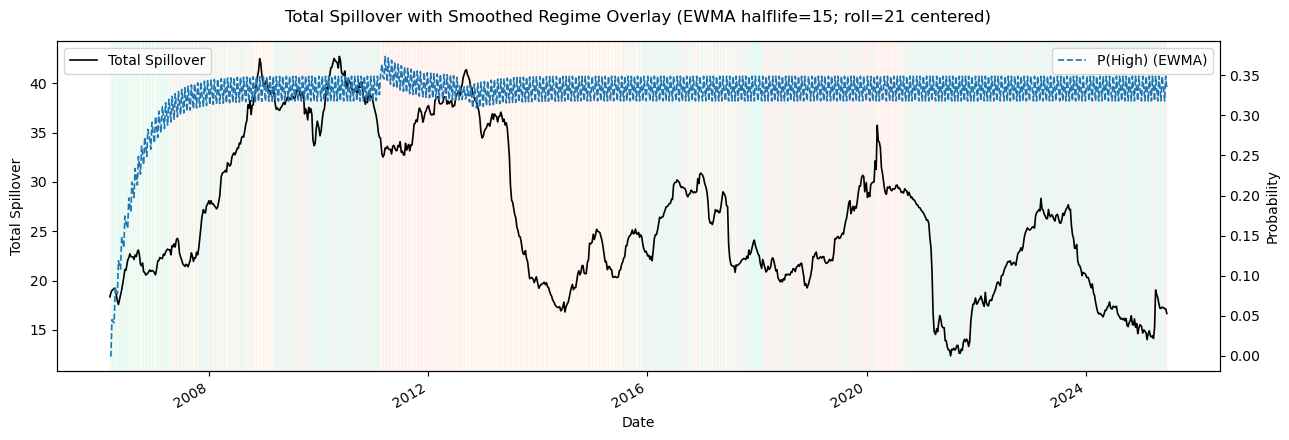

Wrote: outputs/regime_switching/regime_prob_trackA_EWMA.csv outputs/regime_switching/regime_prob_trackA_ROLL.csv outputs/regime_switching/regime_labels_trackA_soft.csv outputs/regime_switching/regime_overlay_trackA.png


In [39]:
# === Smoothed regimes + overlay plot ========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

in_prob  = Path("outputs/regime_switching/regime_prob_trackA.csv")
in_y     = Path("outputs/rolling/rolling_total_H10_W250_S5_fixed.csv")
out_dir  = Path("outputs/regime_switching")
out_dir.mkdir(parents=True, exist_ok=True)

# 1) Load
P = pd.read_csv(in_prob, parse_dates=["Date"]).set_index("Date")
y = pd.read_csv(in_y, parse_dates=["Date"]).set_index("Date")["Total_Spillover"].astype(float)
P = P.reindex(y.index)  # align to spillover index

# 2) Smooth probabilities (two flavors)
#    - EWMA (halflife=15 business days ≈ 3 weeks)
#    - Centered rolling mean (window=21)
P_ewma = P.ewm(halflife=15, adjust=False).mean()
P_roll = P.rolling(window=21, center=True, min_periods=5).mean()

# 3) "Soft" labels from EWMA (argmax of smoothed probs)
cols = list(P.columns)                    # e.g., ["P(High)","P(Med)","P(Low)"]
soft_idx = np.nanargmax(P_ewma.values, axis=1)
soft_labels = pd.Series([cols[i] for i in soft_idx], index=P_ewma.index, name="Regime_Soft")

# 4) Save smoothed artifacts
P_ewma.to_csv(out_dir / "regime_prob_trackA_EWMA.csv", index_label="Date", float_format="%.6f")
P_roll.to_csv(out_dir / "regime_prob_trackA_ROLL.csv", index_label="Date", float_format="%.6f")
soft_labels.to_frame().to_csv(out_dir / "regime_labels_trackA_soft.csv", index_label="Date")

# 5) Plot overlay: spillover + P(High)_EWMA + background by soft regime
#    Choose colors per regime name (handles any ordering gracefully)
palette = {
    "P(High)": "#ff6b6b",  # light red
    "P(Med)" : "#ffd166",  # amber
    "P(Low)" : "#06d6a0",  # green
}
# default if names differ
for c in cols:
    palette.setdefault(c, "#cfcfcf")

fig, ax = plt.subplots(figsize=(13, 4.5))

# Background shading by contiguous soft regime segments
seg_start = None
prev_reg = None
for t, reg in soft_labels.items():
    if pd.isna(reg):
        continue
    if (seg_start is None) or (reg != prev_reg):
        # close previous segment
        if seg_start is not None:
            ax.axvspan(seg_start, t, color=palette.get(prev_reg, "#e0e0e0"), alpha=0.10, lw=0)
        seg_start = t
        prev_reg  = reg
# close last segment
if seg_start is not None:
    ax.axvspan(seg_start, soft_labels.index[-1], color=palette.get(prev_reg, "#e0e0e0"), alpha=0.10, lw=0)

# Foreground: spillover + smoothed P(High)
y.plot(ax=ax, lw=1.2, color="black", label="Total Spillover")
ax.set_ylabel("Total Spillover")

ax2 = ax.twinx()
col_high = next((c for c in cols if "High" in c), cols[0])
P_ewma[col_high].plot(ax=ax2, lw=1.2, label=f"{col_high} (EWMA)", linestyle="--")
ax2.set_ylabel("Probability")

# Legends
leg1 = ax.legend(loc="upper left", frameon=True)
leg2 = ax2.legend(loc="upper right", frameon=True)

ax.set_title("Total Spillover with Smoothed Regime Overlay (EWMA halflife=15; roll=21 centered)", pad=14)
plt.tight_layout()
plt.savefig(out_dir / "regime_overlay_trackA.png", dpi=240)
plt.show()

print("Wrote:",
      out_dir / "regime_prob_trackA_EWMA.csv",
      out_dir / "regime_prob_trackA_ROLL.csv",
      out_dir / "regime_labels_trackA_soft.csv",
      out_dir / "regime_overlay_trackA.png")


In [55]:
# Load all_assets_conditional_vol from CSV
all_assets_conditional_vol = pd.read_csv(
    "all_assets_conditional_vol.csv",  # adjust path if needed
    parse_dates=["Date"]
)


Selected K=3  (AIC: 30366.0, BIC: 30594.2)

Posterior summary (named):
           count      mean       std            min           25%  \
P(Low)   5021.0  0.548079  0.492952   4.795207e-37  6.096303e-09   
P(Med)   5021.0  0.186863  0.383962  1.637395e-107  2.147484e-07   
P(High)  5021.0  0.265057  0.436163  2.961378e-181  2.257727e-09   

                  50%       75%  max  
P(Low)   9.998594e-01  1.000000  1.0  
P(Med)   7.389674e-07  0.000078  1.0  
P(High)  4.889907e-08  0.971785  1.0  

Label counts:
 Regime_Label
Low     2753
High    1331
Med      937
Name: count, dtype: int64

Saved Track B CSVs to: /Users/mileshobson/outputs/regime_switching


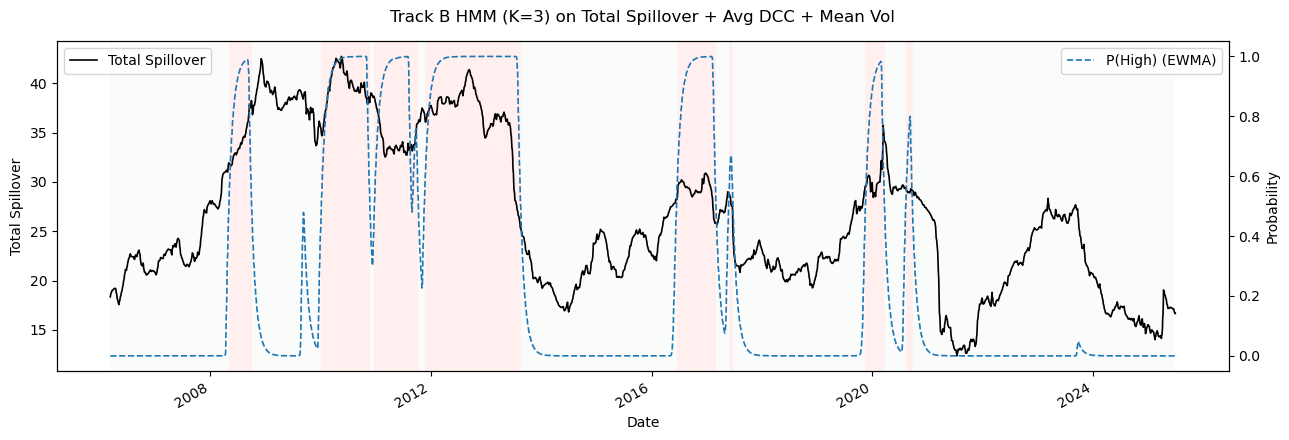

In [59]:
# === Track B: Multivariate HMM (Total Spillover + Avg DCC + Mean Vol) =======

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from hmmlearn.hmm import GaussianHMM

# ----------------------------- Inputs ---------------------------------------
in_total = Path("outputs/rolling/rolling_total_H10_W250_S5_fixed.csv")
out_dir  = Path("outputs/regime_switching")

out_dir.mkdir(parents=True, exist_ok=True)

# 1) Total spillover (Series)
tot = pd.read_csv(in_total, parse_dates=["Date"]).set_index("Date")["Total_Spillover"].astype(float)

# 2) Avg off-diagonal DCC per day (Series) from your long df `dcc_correlations`

# Load DCC correlations from your saved output
dcc_correlations = pd.read_csv(
    "dcc_correlations.csv",  # adjust path if different
    parse_dates=["Date"]
)

dcc = dcc_correlations.copy()
dcc["Date"] = pd.to_datetime(dcc["Date"])
# keep only off-diagonals
dcc_off = (dcc.loc[dcc["Asset1"] != dcc["Asset2"], ["Date", "Correlation"]]
             .groupby("Date")["Correlation"].mean()
             .rename("Avg_DCC"))

# 3) Mean conditional vol across assets per day (Series) from your wide df
vol_wide = all_assets_conditional_vol.copy()
vol_wide["Date"] = pd.to_datetime(vol_wide["Date"])
vol_wide = vol_wide.set_index("Date")
mean_vol = vol_wide.mean(axis=1).rename("Mean_Vol")

# 4) Merge features & clean
X = pd.concat([tot.rename("Total_Spillover"), dcc_off, mean_vol], axis=1).sort_index()
# Optional interpolation for rare gaps, but keep mostly observed values
X = X.asfreq("B")  # business days
X = X.interpolate(limit=5).dropna()

# 5) Standardize columns (z-score) for stable HMM fitting
Xz = (X - X.mean()) / X.std()
cols = X.columns.tolist()  # keep original names
Z = Xz.values  # (T, d)

# ------------------------ Model selection (K=2 vs K=3) ----------------------
def hmm_fit_and_crit(Z, K, random_state=7, n_iter=1000, tol=1e-4):
    hmm = GaussianHMM(n_components=K, covariance_type="full",
                      n_iter=n_iter, tol=tol, random_state=random_state)
    hmm.fit(Z)
    logL = hmm.score(Z)
    T, d = Z.shape
    # parameters count: means K*d, covariances K*d*(d+1)/2, startprob K-1, trans K*(K-1)
    n_params = K*d + K*(d*(d+1)//2) + (K-1) + K*(K-1)
    aic = 2*n_params - 2*logL
    bic = np.log(T)*n_params - 2*logL
    return hmm, logL, aic, bic, n_params

res = {}
for K in (2, 3):
    hmm, logL, aic, bic, n_params = hmm_fit_and_crit(Z, K)
    res[K] = dict(hmm=hmm, logL=logL, aic=aic, bic=bic, n_params=n_params)

bestK = min(res, key=lambda k: res[k]["bic"])
hmm = res[bestK]["hmm"]
print(f"Selected K={bestK}  (AIC: {res[bestK]['aic']:.1f}, BIC: {res[bestK]['bic']:.1f})")

# ------------------------ Posteriors & labeling ------------------------------
post = hmm.predict_proba(Z)                               # (T, K)
P = pd.DataFrame(post, index=X.index, columns=[f"Regime_{j}" for j in range(bestK)])

# Name regimes Low/Med/High by weighted mean of Total_Spillover (original scale)
wmeans = []
y_base = X["Total_Spillover"].values
for j in range(bestK):
    wmeans.append((j, np.average(y_base, weights=P[f"Regime_{j}"].values)))
order = [j for j,_ in sorted(wmeans, key=lambda x: x[1])]
name_map = {order[i]: ["Low","Med","High"][i] for i in range(bestK)}
P_named = P.rename(columns={f"Regime_{j}": f"P({name_map[j]})" for j in range(bestK)})

# Hard labels (argmax)
labels_idx = np.argmax(P.values, axis=1)
labels = pd.Series([name_map[i] for i in labels_idx], index=P.index, name="Regime_Label")

print("\nPosterior summary (named):\n", P_named.describe().T)
print("\nLabel counts:\n", labels.value_counts())

# ------------------------ Transition matrix & durations ----------------------
# Expected duration ~ 1 / (1 - p_ii)
trans = pd.DataFrame(hmm.transmat_,
                     index=[name_map[i] for i in range(bestK)],
                     columns=[name_map[i] for i in range(bestK)])
dur = 1.0 / (1.0 - np.diag(hmm.transmat_))
dur = pd.Series(dur, index=trans.index, name="Expected_Duration")

# ------------------------ Save artifacts ------------------------------------
out_dir.joinpath("regime_prob_trackB.csv").write_text("")  # ensure truncation
P_named.to_csv(out_dir / "regime_prob_trackB.csv", index_label="Date", float_format="%.8f")
labels.to_frame().to_csv(out_dir / "regime_labels_trackB.csv", index_label="Date")
trans.to_csv(out_dir / "regime_transition_matrix_trackB.csv", index_label="from\\to")
dur.to_csv(out_dir / "regime_expected_durations_trackB.csv")

# Also save features used (helps reproducibility)
X.to_csv(out_dir / "trackB_features_used.csv", index_label="Date")

print("\nSaved Track B CSVs to:", out_dir.resolve())

# ------------------------ Plot overlay (like Track A) -----------------------
fig, ax = plt.subplots(figsize=(13, 4.5))
X["Total_Spillover"].plot(ax=ax, lw=1.2, color="black", label="Total Spillover")
ax.set_ylabel("Total Spillover")

# Smoothed P(High) if exists; else highest-order regime
col_high = next((c for c in P_named.columns if "High" in c), P_named.columns[-1])
P_smooth = P_named[col_high].ewm(halflife=15, adjust=False).mean()
ax2 = ax.twinx(); P_smooth.plot(ax=ax2, lw=1.2, linestyle="--", label=f"{col_high} (EWMA)")
ax2.set_ylabel("Probability")

# Background shading by soft labels from P_smooth
soft = pd.Series(np.where(P_smooth >= 0.5, col_high, "Other"), index=P_smooth.index)
palette = {"P(High)": "#ff6b6b", "P(Med)": "#ffd166", "P(Low)": "#06d6a0", "Other": "#cfd8dc"}
start, prev = None, None
for t, reg in soft.items():
    if start is None: start, prev = t, reg; continue
    if reg != prev:
        ax.axvspan(start, t, color=palette.get(prev, "#e0e0e0"), alpha=0.10, lw=0)
        start, prev = t, reg
ax.axvspan(start, soft.index[-1], color=palette.get(prev, "#e0e0e0"), alpha=0.10, lw=0)

ax.legend(loc="upper left", frameon=True)
ax2.legend(loc="upper right", frameon=True)
ax.set_title(f"Track B HMM (K={bestK}) on Total Spillover + Avg DCC + Mean Vol", pad=14)
plt.tight_layout(); plt.savefig(out_dir / "regime_overlay_trackB.png", dpi=240); plt.show()


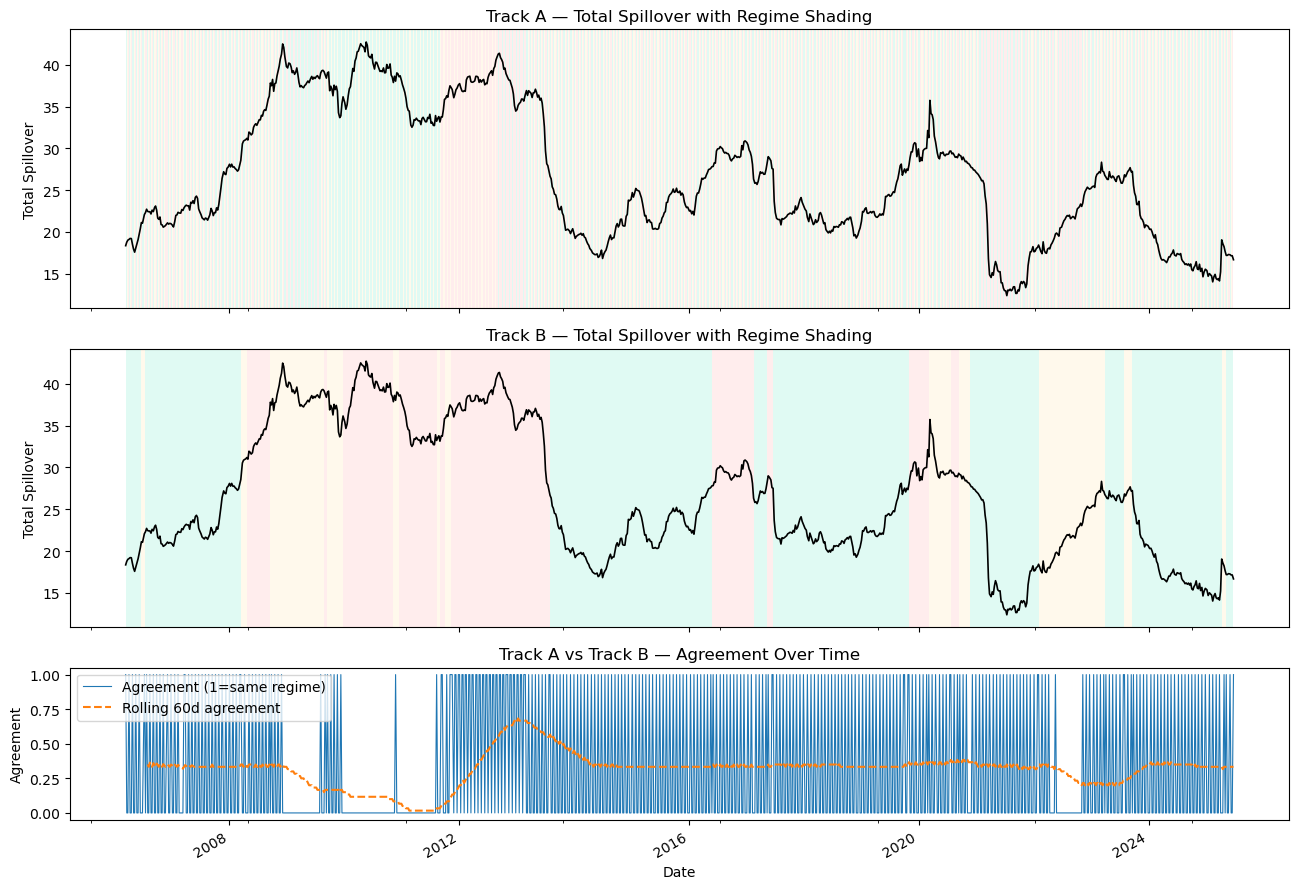

Saved: outputs/regime_switching/trackAB_comparison.png outputs/regime_switching/trackAB_agreement_summary.csv outputs/regime_switching/trackAB_confusion_matrix.csv


In [62]:
# === Track A vs Track B: side-by-side comparison & agreement =================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

out_dir = Path("outputs/regime_switching")
out_dir.mkdir(parents=True, exist_ok=True)

# 1) Load series + labels
y = pd.read_csv("outputs/rolling/rolling_total_H10_W250_S5_fixed.csv",
                parse_dates=["Date"]).set_index("Date")["Total_Spillover"].astype(float)

labA = pd.read_csv(out_dir / "regime_labels_trackA.csv", parse_dates=["Date"])\
         .set_index("Date")["Regime_Label"].rename("TrackA")
labB = pd.read_csv(out_dir / "regime_labels_trackB.csv", parse_dates=["Date"])\
         .set_index("Date")["Regime_Label"].rename("TrackB")

# Align to common index
df = pd.concat([y.rename("Total_Spillover"), labA, labB], axis=1).dropna()

# 2) Agreement metrics
agree = (df["TrackA"] == df["TrackB"]).astype(int).rename("Agree")
agree_roll = agree.rolling(60, min_periods=20).mean().rename("Agree_60d")  # 60 business days ~ 3 months

# Confusion matrix (overall)
conf = pd.crosstab(df["TrackA"], df["TrackB"]).sort_index(axis=0).sort_index(axis=1)

# Simple palette that works with either label order
pal = {"Low":"#06d6a0", "Med":"#ffd166", "High":"#ff6b6b"}

# 3) Helper to shade regimes
def shade_regimes(ax, labels, palette, alpha=0.10):
    start = None; prev = None
    for t, reg in labels.items():
        if pd.isna(reg): continue
        if start is None: start, prev = t, reg; continue
        if reg != prev:
            ax.axvspan(start, t, color=palette.get(prev, "#e0e0e0"), alpha=alpha, lw=0)
            start, prev = t, reg
    if start is not None:
        ax.axvspan(start, labels.index[-1], color=palette.get(prev, "#e0e0e0"), alpha=alpha, lw=0)

# 4) Plot — three panels
fig, axes = plt.subplots(3, 1, figsize=(13, 9), sharex=True,
                         gridspec_kw={"height_ratios":[2.2, 2.2, 1.2]})

# Panel 1: Track A overlay
ax = axes[0]
shade_regimes(ax, df["TrackA"], pal, alpha=0.12)
df["Total_Spillover"].plot(ax=ax, color="black", lw=1.2)
ax.set_title("Track A — Total Spillover with Regime Shading")
ax.set_ylabel("Total Spillover")

# Panel 2: Track B overlay
ax = axes[1]
shade_regimes(ax, df["TrackB"], pal, alpha=0.12)
df["Total_Spillover"].plot(ax=ax, color="black", lw=1.2)
ax.set_title("Track B — Total Spillover with Regime Shading")
ax.set_ylabel("Total Spillover")

# Panel 3: Agreement
ax = axes[2]
agree.plot(ax=ax, lw=0.8, label="Agreement (1=same regime)")
agree_roll.plot(ax=ax, lw=1.5, linestyle="--", label="Rolling 60d agreement")
ax.set_ylim(-0.05, 1.05)
ax.set_ylabel("Agreement")
ax.legend(loc="upper left", frameon=True)
ax.set_title("Track A vs Track B — Agreement Over Time")

plt.tight_layout()
figpath = out_dir / "trackAB_comparison.png"
plt.savefig(figpath, dpi=240)
plt.show()

# 5) Save summary stats
summary = {
    "overall_agreement": float(agree.mean()),
    "rolling_60d_agreement_mean": float(agree_roll.mean(skipna=True)),
    "n_obs": int(len(df))
}
sumdf = pd.DataFrame(summary, index=[0])
sumdf.to_csv(out_dir / "trackAB_agreement_summary.csv", index=False)
conf.to_csv(out_dir / "trackAB_confusion_matrix.csv", index_label="TrackA\\TrackB")

print("Saved:",
      figpath,
      out_dir / "trackAB_agreement_summary.csv",
      out_dir / "trackAB_confusion_matrix.csv")


In [66]:
!pip install ruptures

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.1/308.1 kB 4.7 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ruptures: filename=ruptures-1.1.9-cp312-cp312-macosx_11_0_arm64.whl size=466783 sha256=b14da3328ec7b630ced04a646b109a2fb5a7972949ba643784f65b3f5564d136
  Stored in directory: /Users/mileshobson/Library/Caches/pip/wheels/99/2d/4d/15931b829a4f53921dcbbb6de97e7cc2a6d2f09ea1428af028
Successfully built ruptures


Detected 9 breaks with penalty=10
Break dates: DatetimeIndex(['2007-11-26', '2008-08-06', '2013-07-25', '2016-02-24',
               '2017-06-12', '2019-08-21', '2021-02-19', '2022-07-12',
               '2024-01-08'],
              dtype='datetime64[ns]', name='Date', freq=None)


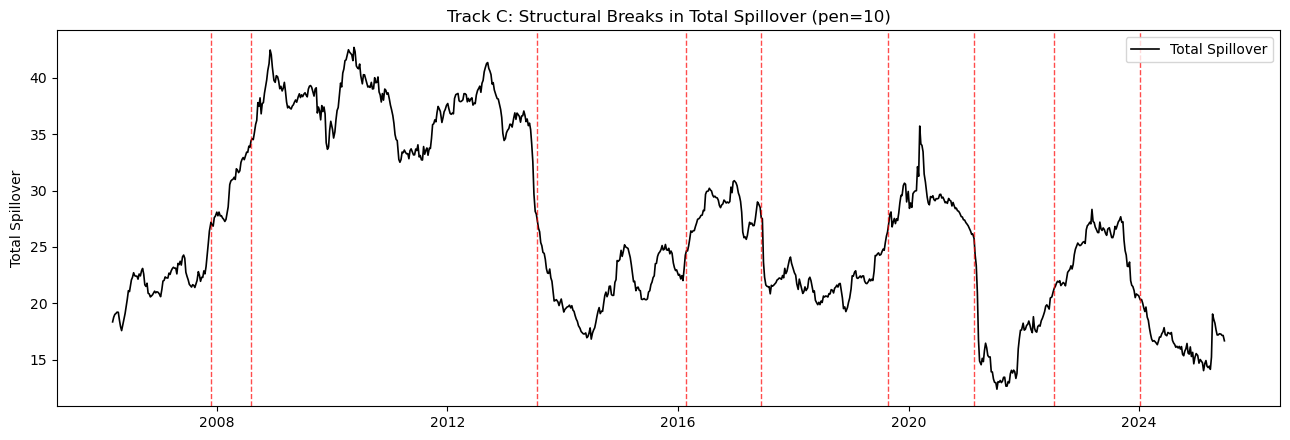

Saved: outputs/regime_switching/trackC_break_dates.csv outputs/regime_switching/trackC_breaks_plot.png


In [68]:
# === Track C: Structural Break Detection on Total Spillover =================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from pathlib import Path

# ----------------------------- Inputs ---------------------------------------
in_total = Path("outputs/rolling/rolling_total_H10_W250_S5_fixed.csv")
out_dir  = Path("outputs/regime_switching")
out_dir.mkdir(parents=True, exist_ok=True)

# Load total spillover
tot = pd.read_csv(in_total, parse_dates=["Date"]).set_index("Date")["Total_Spillover"].astype(float)
y = tot.dropna().values  # array for ruptures

# ---------------------- Break detection (Pelt) ------------------------------
# Model: "rbf" captures level/variance shifts; try "l2" if only mean shifts
algo = rpt.Pelt(model="rbf").fit(y)

# Penalty can be tuned; higher pen = fewer breaks, lower pen = more breaks
penalty = 10
break_idx = algo.predict(pen=penalty)  # returns end indexes of each segment
break_dates = tot.index[np.array(break_idx[:-1])]  # drop final point
print(f"Detected {len(break_dates)} breaks with penalty={penalty}")
print("Break dates:", break_dates)

# ---------------------- Save results ----------------------------------------
pd.Series(break_dates, name="Break_Date").to_csv(out_dir / "trackC_break_dates.csv", index=False)

# ---------------------- Plot with breaks ------------------------------------
fig, ax = plt.subplots(figsize=(13, 4.5))
ax.plot(tot.index, tot.values, color="black", lw=1.2, label="Total Spillover")

for bd in break_dates:
    ax.axvline(bd, color="red", linestyle="--", lw=1, alpha=0.7)

ax.set_title(f"Track C: Structural Breaks in Total Spillover (pen={penalty})")
ax.set_ylabel("Total Spillover")
ax.legend()
plt.tight_layout()
plt.savefig(out_dir / "trackC_breaks_plot.png", dpi=240)
plt.show()

print("Saved:", out_dir / "trackC_break_dates.csv", out_dir / "trackC_breaks_plot.png")


In [71]:
# === Track C: Map breaks to events & segment stats ===========================
import pandas as pd
from pathlib import Path

out_dir = Path("outputs/regime_switching")

# Load break dates from Track C CSV
break_dates = pd.read_csv(out_dir / "trackC_break_dates.csv", parse_dates=["Break_Date"])["Break_Date"].tolist()

# Add start and end of sample
tot = pd.read_csv("outputs/rolling/rolling_total_H10_W250_S5_fixed.csv",
                  parse_dates=["Date"]).set_index("Date")["Total_Spillover"].astype(float)
all_dates = [tot.index.min()] + break_dates + [tot.index.max()]

# Event mapping dictionary (can refine descriptions)
event_map = {
    pd.Timestamp("2007-11-26"): "Onset of Global Financial Crisis (subprime contagion)",
    pd.Timestamp("2008-08-06"): "Lehman phase of GFC",
    pd.Timestamp("2013-07-25"): "Post-Eurozone debt crisis / taper talk",
    pd.Timestamp("2016-02-24"): "China slowdown & oil price crash",
    pd.Timestamp("2017-06-12"): "Pre-volatility spike (low-vol regime peak)",
    pd.Timestamp("2019-08-21"): "Pre-COVID risk build-up (trade war, yield curve inversion)",
    pd.Timestamp("2021-02-19"): "Post-COVID liquidity rotation",
    pd.Timestamp("2022-07-12"): "Inflation & energy shock (Ukraine war)",
    pd.Timestamp("2024-01-08"): "Post-tightening adjustment"
}

# Build mapping table
mapping_rows = []
for bd in break_dates:
    mapping_rows.append({
        "Break_Date": bd,
        "Likely_Event": event_map.get(bd, "Unclassified")
    })
mapping_df = pd.DataFrame(mapping_rows)
mapping_df.to_csv(out_dir / "trackC_break_event_mapping.csv", index=False)

# Compute segment averages
segment_rows = []
for i in range(len(all_dates) - 1):
    seg_start = all_dates[i]
    seg_end = all_dates[i+1]
    seg_data = tot.loc[seg_start:seg_end]
    segment_rows.append({
        "Segment": i+1,
        "Start": seg_start,
        "End": seg_end,
        "Days": len(seg_data),
        "Avg_Spillover": seg_data.mean()
    })
segment_df = pd.DataFrame(segment_rows)
segment_df.to_csv(out_dir / "trackC_segment_summary.csv", index=False)

print("Saved mapping:", out_dir / "trackC_break_event_mapping.csv")
print("Saved segment stats:", out_dir / "trackC_segment_summary.csv")
segment_df


Saved mapping: outputs/regime_switching/trackC_break_event_mapping.csv
Saved segment stats: outputs/regime_switching/trackC_segment_summary.csv


,Segment,Start,End,Days,Avg_Spillover
0,1,2006-03-13,2007-11-26,86,21.812073
1,2,2007-11-26,2008-08-06,36,30.219402
2,3,2008-08-06,2013-07-25,251,37.370185
3,4,2013-07-25,2016-02-24,131,21.614280
4,5,2016-02-24,2017-06-12,66,28.180132
5,6,2017-06-12,2019-08-21,111,22.075101
6,7,2019-08-21,2021-02-19,76,28.961567
7,8,2021-02-19,2022-07-12,71,16.572234
8,9,2022-07-12,2024-01-08,76,24.585400
9,10,2024-01-08,2025-06-24,74,16.634175


Saved: outputs/regime_switching/trackC_segment_total_spillover_summary.csv outputs/regime_switching/trackC_segment_net_means.csv outputs/regime_switching/trackC_segment_top_transmitters_receivers.csv


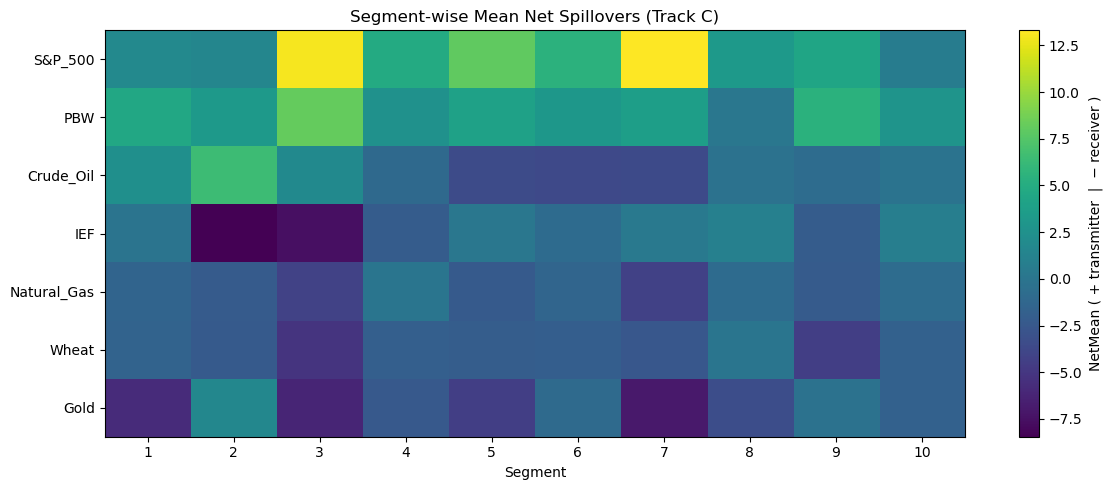

Saved: outputs/regime_switching/trackC_segment_net_means_heatmap.png


In [74]:
# === Track C → Segment-wise DY summaries (no re-estimation; uses rolling outputs) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

out_dir = Path("outputs/regime_switching")
out_dir.mkdir(parents=True, exist_ok=True)

# ---- 1) Load base series and Track C breaks --------------------------------
total = pd.read_csv("outputs/rolling/rolling_total_H10_W250_S5_fixed.csv",
                    parse_dates=["Date"]).set_index("Date")["Total_Spillover"].astype(float)

break_dates = pd.read_csv(out_dir / "trackC_break_dates.csv",
                          parse_dates=["Break_Date"])["Break_Date"].tolist()

# Build segment boundaries (start of sample, each break, end of sample)
bounds = [total.index.min()] + break_dates + [total.index.max()]
segments = [(bounds[i], bounds[i+1]) for i in range(len(bounds)-1)]

# ---- 2) Load DY rolling outputs --------------------------------------------
# Required: NET (per-asset). Optional: TO, FROM (per-asset).
net = pd.read_csv("outputs/rolling/rolling_net_H10_W250_S5_fixed.csv",
                  parse_dates=["Date"]).set_index("Date")

# Try to/from if available; otherwise skip
to_df = from_df = None
to_path   = Path("outputs/rolling/rolling_to_H10_W250_S5_fixed.csv")
from_path = Path("outputs/rolling/rolling_from_H10_W250_S5_fixed.csv")
if to_path.exists():
    to_df = pd.read_csv(to_path, parse_dates=["Date"]).set_index("Date")
if from_path.exists():
    from_df = pd.read_csv(from_path, parse_dates=["Date"]).set_index("Date")

# Align indices (in case of different sampling)
net = net.reindex(total.index).interpolate(limit=3)
if to_df is not None:
    to_df = to_df.reindex(total.index).interpolate(limit=3)
if from_df is not None:
    from_df = from_df.reindex(total.index).interpolate(limit=3)

# ---- 3) Compute segment summaries ------------------------------------------
seg_rows = []
top_rows = []
net_means_by_seg = []

for s, (start, end) in enumerate(segments, 1):
    # Include both endpoints; if you prefer [start, end) drop the last day via .loc[start:end - 1day]
    seg_slice = slice(start, end)
    tot_seg = total.loc[seg_slice]
    net_seg = net.loc[seg_slice]

    if len(tot_seg) == 0 or len(net_seg) == 0:
        continue

    # Segment-level stats
    seg_rows.append({
        "Segment": s,
        "Start": start,
        "End": end,
        "Days": int(len(tot_seg)),
        "Avg_Total_Spillover": float(tot_seg.mean()),
        "Median_Total_Spillover": float(tot_seg.median())
    })

    # Per-asset means
    net_mean = net_seg.mean(axis=0).sort_values(ascending=False)  # + = transmitter, - = receiver
    net_means_by_seg.append(
        pd.DataFrame({"Segment": s, "Asset": net_mean.index, "NetMean": net_mean.values})
    )

    # Top transmitters/receivers
    top_tx = net_mean.head(min(3, len(net_mean)))
    top_rx = net_mean.tail(min(3, len(net_mean)))

    for rank, (asset, val) in enumerate(top_tx.items(), 1):
        top_rows.append({"Segment": s, "Type": "Top Transmitter", "Rank": rank,
                         "Asset": asset, "NetMean": float(val)})
    for rank, (asset, val) in enumerate(top_rx.items(), 1):
        top_rows.append({"Segment": s, "Type": "Top Receiver", "Rank": rank,
                         "Asset": asset, "NetMean": float(val)})

# Optional To/From segment means
to_means_long = from_means_long = None
if to_df is not None:
    to_means = []
    for s, (start, end) in enumerate(segments, 1):
        seg = to_df.loc[start:end]
        if len(seg): to_means.append(seg.mean().rename(s))
    if to_means:
        to_means_long = pd.concat(to_means, axis=1).T.reset_index().melt(
            id_vars="index", var_name="Asset", value_name="ToMean").rename(columns={"index":"Segment"})
if from_df is not None:
    from_means = []
    for s, (start, end) in enumerate(segments, 1):
        seg = from_df.loc[start:end]
        if len(seg): from_means.append(seg.mean().rename(s))
    if from_means:
        from_means_long = pd.concat(from_means, axis=1).T.reset_index().melt(
            id_vars="index", var_name="Asset", value_name="FromMean").rename(columns={"index":"Segment"})

# ---- 4) Save CSV artifacts --------------------------------------------------
seg_summary = pd.DataFrame(seg_rows)
seg_summary.to_csv(out_dir / "trackC_segment_total_spillover_summary.csv", index=False)

net_means_long = pd.concat(net_means_by_seg, ignore_index=True) if net_means_by_seg else pd.DataFrame()
net_means_long.to_csv(out_dir / "trackC_segment_net_means.csv", index=False)

pd.DataFrame(top_rows).to_csv(out_dir / "trackC_segment_top_transmitters_receivers.csv", index=False)

# Merge To/From if available
if to_means_long is not None or from_means_long is not None:
    merged = net_means_long.copy()
    if to_means_long is not None:
        merged = merged.merge(to_means_long, on=["Segment", "Asset"], how="left")
    if from_means_long is not None:
        merged = merged.merge(from_means_long, on=["Segment", "Asset"], how="left")
    merged.to_csv(out_dir / "trackC_segment_net_to_from_means.csv", index=False)

print("Saved:",
      out_dir / "trackC_segment_total_spillover_summary.csv",
      out_dir / "trackC_segment_net_means.csv",
      out_dir / "trackC_segment_top_transmitters_receivers.csv")

# ---- 5) Quick heatmap: per-asset NetMean by segment ------------------------
# (nice for the dissertation to show role changes across segments)
if not net_means_long.empty:
    pivot = net_means_long.pivot(index="Asset", columns="Segment", values="NetMean").fillna(0.0)
    # sort assets by overall transmitter strength
    pivot = pivot.loc[pivot.mean(axis=1).sort_values(ascending=False).index]

    fig, ax = plt.subplots(figsize=(12, max(5, 0.35*len(pivot))))
    im = ax.imshow(pivot.values, aspect="auto")
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns)
    ax.set_xlabel("Segment"); ax.set_title("Segment-wise Mean Net Spillovers (Track C)")
    cbar = plt.colorbar(im, ax=ax); cbar.set_label("NetMean ( + transmitter  |  − receiver )")
    plt.tight_layout()
    plt.savefig(out_dir / "trackC_segment_net_means_heatmap.png", dpi=240)
    plt.show()
    print("Saved:", out_dir / "trackC_segment_net_means_heatmap.png")


In [95]:
# === Track C: Segment-wise VAR + GFEVD re-estimation (safe version) =========
import pandas as pd
import numpy as np
from pathlib import Path
from statsmodels.tsa.api import VAR

out_dir = Path("outputs/regime_switching")
out_dir.mkdir(parents=True, exist_ok=True)

# 0) Path to your LOG RETURNS file (replace if different)
rets_path = "all_assets_log_returns_cleaned.csv"
rets = pd.read_csv(rets_path, parse_dates=["Date"]).set_index("Date").sort_index()

# Keep only fully observed columns (optional but stabilizes VAR)
rets = rets.dropna(axis=1, how="any")
K_expected = rets.shape[1]

# Load Track C break dates
break_dates = pd.read_csv(out_dir / "trackC_break_dates.csv", parse_dates=["Break_Date"])["Break_Date"].tolist()

# Segment bounds
bounds = [rets.index.min()] + break_dates + [rets.index.max()]
segments = [(bounds[i], bounds[i+1]) for i in range(len(bounds)-1)]

def dy_spillover(segment_df: pd.DataFrame, horizon=10, maxlags=10, ic="aic"):
    """
    Diebold–Yilmaz via VAR + FEVD for a given segment (safe).
    Returns: total, to_s, from_s, net_s, fevd_mat, lag_used
    """
    X = segment_df.dropna()
    if X.shape[0] < 60 or X.shape[1] < 2:
        raise ValueError(f"Insufficient data for VAR: T={X.shape[0]}, K={X.shape[1]}")

    # Lag selection
    model = VAR(X)
    sel = model.select_order(maxlags)
    p = getattr(sel, ic, None)
    if p is None:
        # fallback: pick smallest non-None among ICs
        candidates = {k: getattr(sel, k, None) for k in ["aic","bic","hqic","fpe"]}
        p = min(v for v in candidates.values() if v is not None)
    p = int(max(1, min(maxlags, p)))

    res = model.fit(p)

    fevd = res.fevd(horizon)
    decomp = np.asarray(fevd.decomp)  # shape (K, H, K)
    if decomp.shape[0] != decomp.shape[2]:
        raise ValueError(f"Unexpected FEVD shape {decomp.shape}, expected (K,H,K) with first=last.")
    # Swap axes to get (K, K, H)
    decomp = np.swapaxes(decomp, 1, 2)
    M = decomp[:, :, -1]  # last horizon slice (K x K)


  

    # Normalize rows to sum 1 (guard zeros)
    row_sums = M.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0.0] = 1.0
    M = M / row_sums

    # DY measures (columns=j transmitters; rows=i receivers)
    to_   = M.sum(axis=0) - np.diag(M)   # how much j transmits to others
    from_ = M.sum(axis=1) - np.diag(M)   # how much i receives from others
    net_  = to_ - from_
    total = float((M.sum() - np.trace(M)) / K)

    assets = X.columns
    to_s   = pd.Series(to_,   index=assets, name="TO")
    from_s = pd.Series(from_, index=assets, name="FROM")
    net_s  = pd.Series(net_,  index=assets, name="NET")

    return total, to_s, from_s, net_s, M, p

# Loop segments
summ = []
for s, (start, end) in enumerate(segments, 1):
    seg = rets.loc[start:end]

    # Basic checks
    if len(seg) < 60:
        print(f"[Skip] Segment {s}: too short (T={len(seg)})")
        continue
    if seg.isna().any().any():
        seg = seg.dropna()
        if len(seg) < 60:
            print(f"[Skip] Segment {s}: too many NaNs after drop (T={len(seg)})")
            continue

    try:
        total_spill, to_s, from_s, net_s, fevd_mat, lag_used = dy_spillover(seg, horizon=10, maxlags=10, ic="aic")
    except Exception as e:
        print(f"[Skip] Segment {s} ({start.date()}–{end.date()}): {e}")
        continue

    summ.append({
        "Segment": s, "Start": start, "End": end, "Days": len(seg),
        "Lag_Used": lag_used, "Total_Spillover": total_spill
    })

    # Save per-asset measures
    pd.concat([to_s, from_s, net_s], axis=1).to_csv(out_dir / f"trackC_reestimate_segment{s}_DY_measures.csv",
                                                    index_label="Asset")

    # Save FEVD matrix
    pd.DataFrame(fevd_mat, index=seg.columns, columns=seg.columns) \
      .to_csv(out_dir / f"trackC_reestimate_segment{s}_FEVD_matrix.csv")

# Summary
pd.DataFrame(summ).to_csv(out_dir / "trackC_reestimate_VAR_summary.csv", index=False)
print("Saved:", out_dir / "trackC_reestimate_VAR_summary.csv")


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dat

Saved: outputs/regime_switching/trackC_reestimate_VAR_summary.csv


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [101]:
# Rebuild Track C re-estimation summary from FEVD matrices on disk
import pandas as pd
import numpy as np
from pathlib import Path
import re

out_dir = Path("outputs/regime_switching")
rets_path = "all_assets_log_returns_cleaned.csv"  # adjust if different

# 1) Load returns to get segment day counts
rets = pd.read_csv(rets_path, parse_dates=["Date"]).set_index("Date").sort_index()

# 2) Get break dates and build segment bounds
bd = pd.read_csv(out_dir / "trackC_break_dates.csv", parse_dates=["Break_Date"])["Break_Date"].tolist()
bounds = [rets.index.min()] + bd + [rets.index.max()]
segments = [(bounds[i], bounds[i+1]) for i in range(len(bounds)-1)]

# 3) Walk FEVD files and compute Total Spillover from FEVD
#    Total spillover = (sum of off-diagonal elements) / K
rows = []
fevd_files = sorted(out_dir.glob("trackC_reestimate_segment*_FEVD_matrix.csv"), 
                    key=lambda p: int(re.search(r"segment(\d+)", p.stem).group(1)))

for f in fevd_files:
    seg = int(re.search(r"segment(\d+)", f.stem).group(1))
    M = pd.read_csv(f, index_col=0).values
    K = M.shape[0]
    offdiag_sum = M.sum() - np.trace(M)
    total_spill = float(offdiag_sum / K)

    # segment meta
    start, end = segments[seg-1]
    days = int(len(rets.loc[start:end]))

    # If you saved lag info elsewhere, you could merge it; for now we leave Lag_Used blank
    rows.append({"Segment": seg, "Start": start, "End": end, "Days": days,
                 "Lag_Used": np.nan, "Total_Spillover": total_spill})

summary = pd.DataFrame(rows).sort_values("Segment").reset_index(drop=True)
summary.to_csv(out_dir / "trackC_reestimate_VAR_summary.csv", index=False)
print("Rebuilt:", (out_dir / "trackC_reestimate_VAR_summary.csv").resolve())
summary.head()


Rebuilt: /Users/mileshobson/outputs/regime_switching/trackC_reestimate_VAR_summary.csv


,Segment,Start,End,Days,Lag_Used,Total_Spillover
0,1,2005-03-04,2007-11-26,675,NaN,0.134205
1,2,2007-11-26,2008-08-06,176,NaN,0.277794
2,3,2008-08-06,2013-07-25,1251,NaN,0.221135
3,4,2013-07-25,2016-02-24,651,NaN,0.134458
4,5,2016-02-24,2017-06-12,326,NaN,0.162872


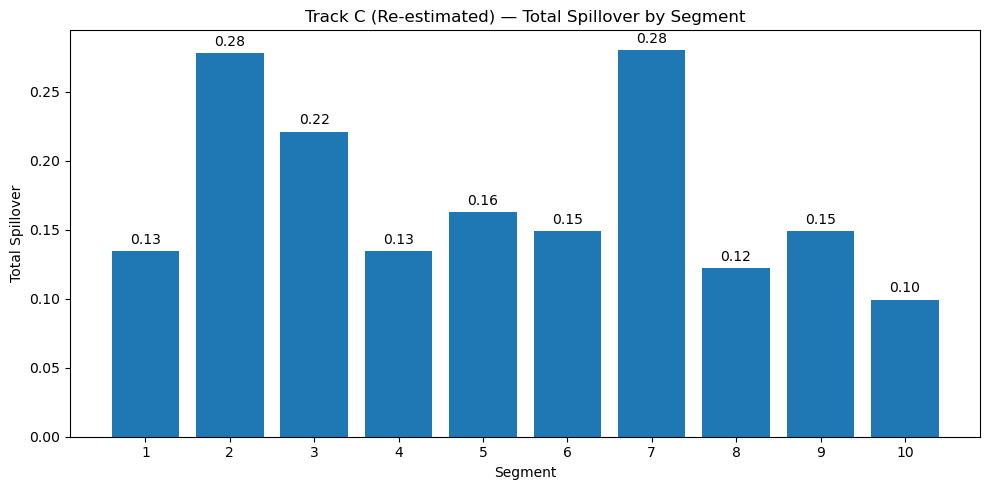

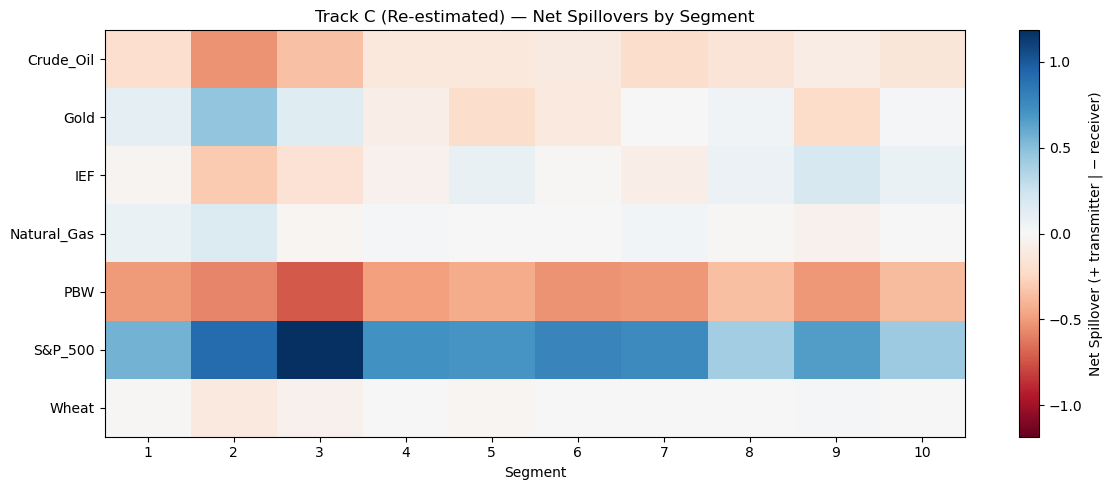

In [104]:
# Visuals for re-estimated Track C segments
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re

out_dir = Path("outputs/regime_switching")

# 1) Total spillover bar chart
summary = pd.read_csv(out_dir / "trackC_reestimate_VAR_summary.csv", parse_dates=["Start","End"])
plt.figure(figsize=(10,5))
plt.bar(summary["Segment"], summary["Total_Spillover"])
plt.xticks(summary["Segment"])
plt.ylabel("Total Spillover")
plt.xlabel("Segment")
plt.title("Track C (Re-estimated) — Total Spillover by Segment")
for i, val in enumerate(summary["Total_Spillover"], 1):
    plt.text(i, val + 0.003, f"{val:.2f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# 2) Heatmap of NET by asset & segment
import pandas as pd
import numpy as np

frames = []
for f in sorted(out_dir.glob("trackC_reestimate_segment*_DY_measures.csv"),
                key=lambda p: int(re.search(r"segment(\d+)", p.stem).group(1))):
    seg = int(re.search(r"segment(\d+)", f.stem).group(1))
    df = pd.read_csv(f)
    df["Segment"] = seg
    frames.append(df)
all_meas = pd.concat(frames, ignore_index=True)

pivot = all_meas.pivot(index="Asset", columns="Segment", values="NET").fillna(0.0)
# symmetric color range for transmitters(+) vs receivers(-)
v = float(np.nanmax(np.abs(pivot.values)))
plt.figure(figsize=(12, max(5, 0.4*len(pivot))))
im = plt.imshow(pivot.values, aspect="auto", vmin=-v, vmax=v, cmap="RdBu")
plt.colorbar(im, label="Net Spillover (+ transmitter | − receiver)")
plt.xticks(range(pivot.shape[1]), pivot.columns)
plt.yticks(range(pivot.shape[0]), pivot.index)
plt.xlabel("Segment"); plt.title("Track C (Re-estimated) — Net Spillovers by Segment")
plt.tight_layout(); plt.show()


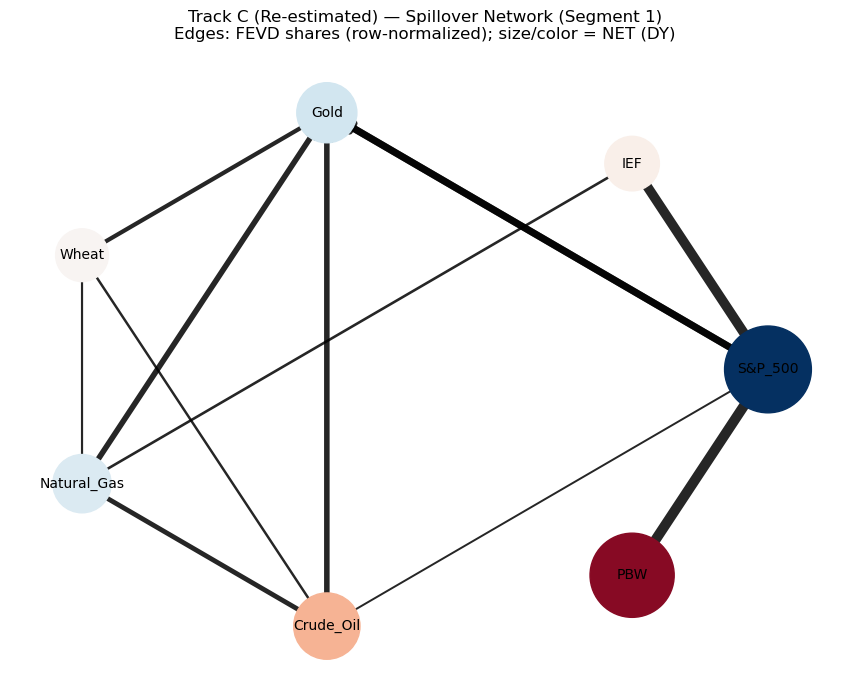

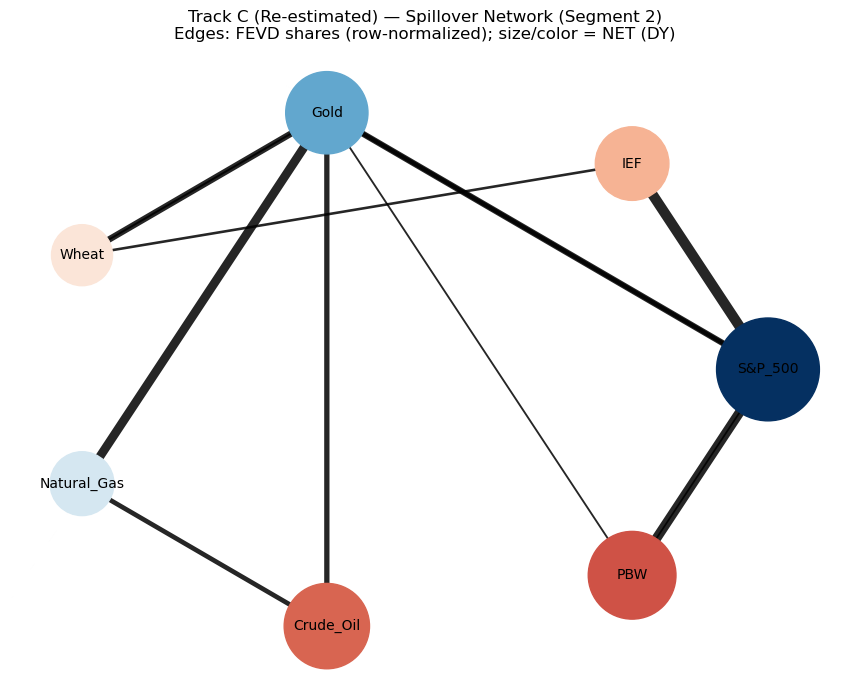

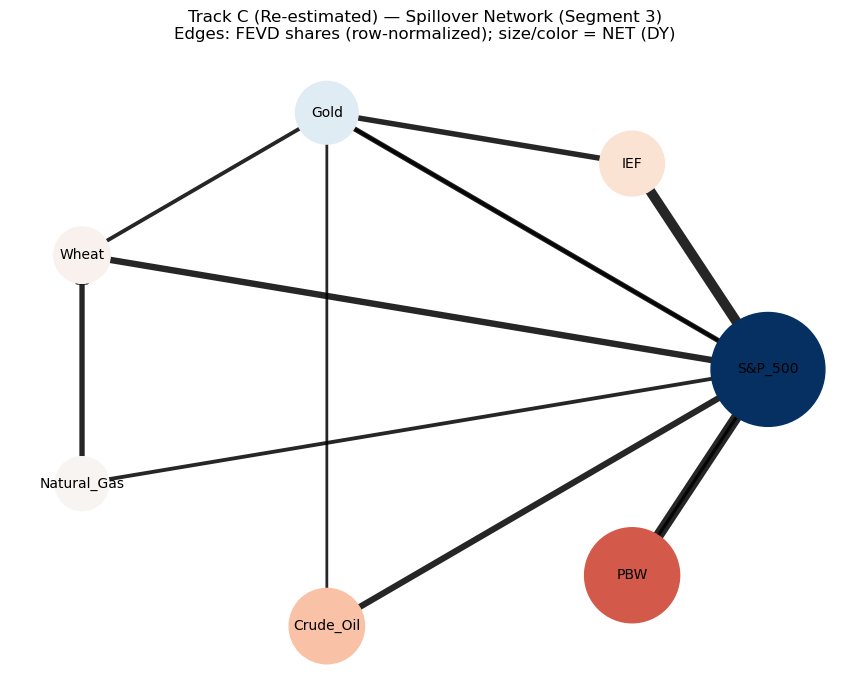

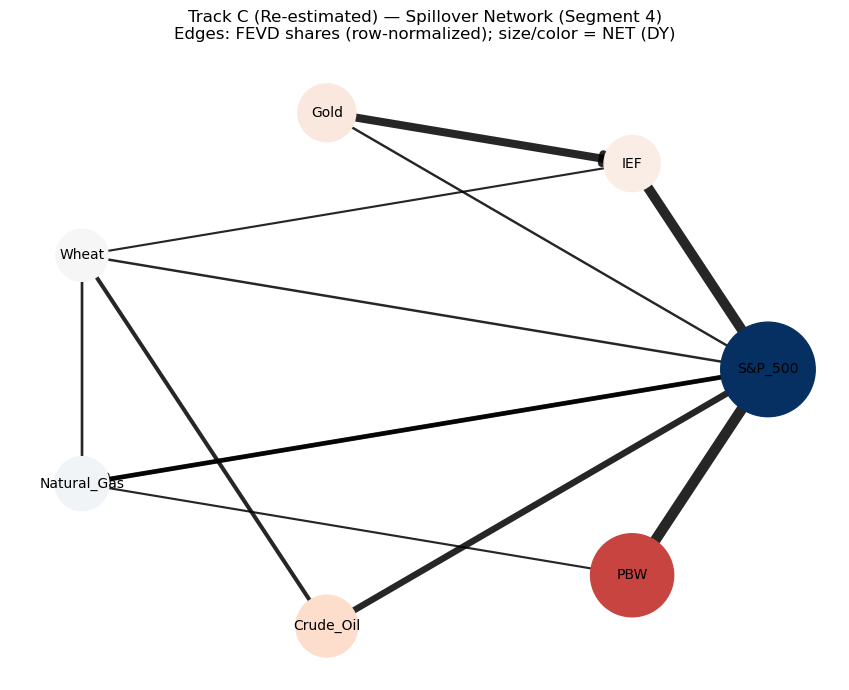

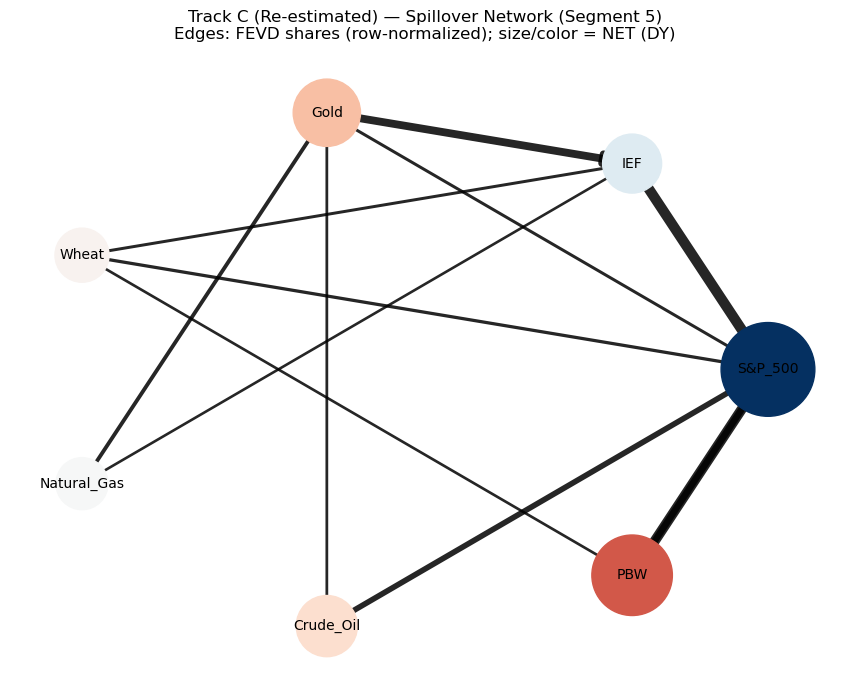

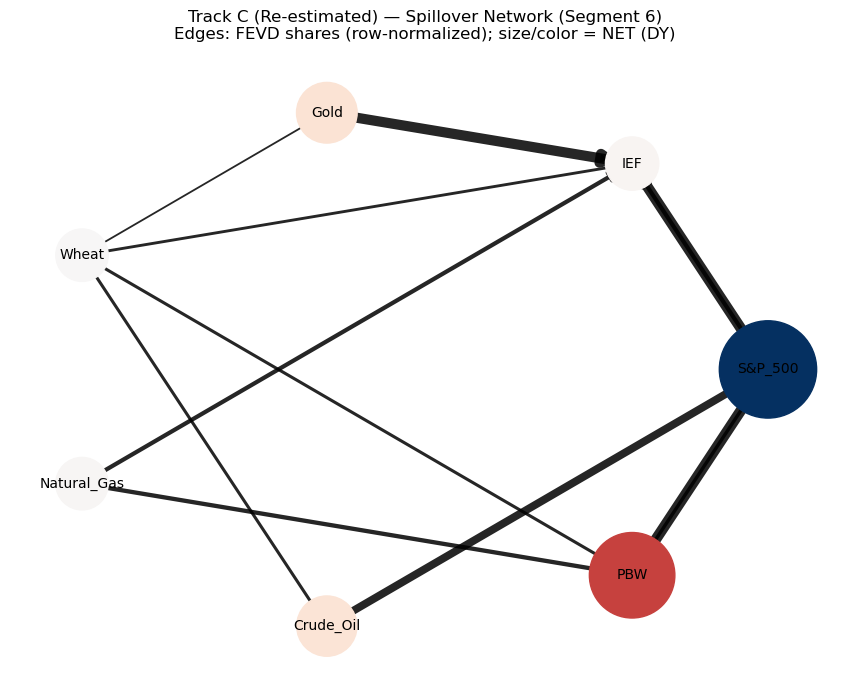

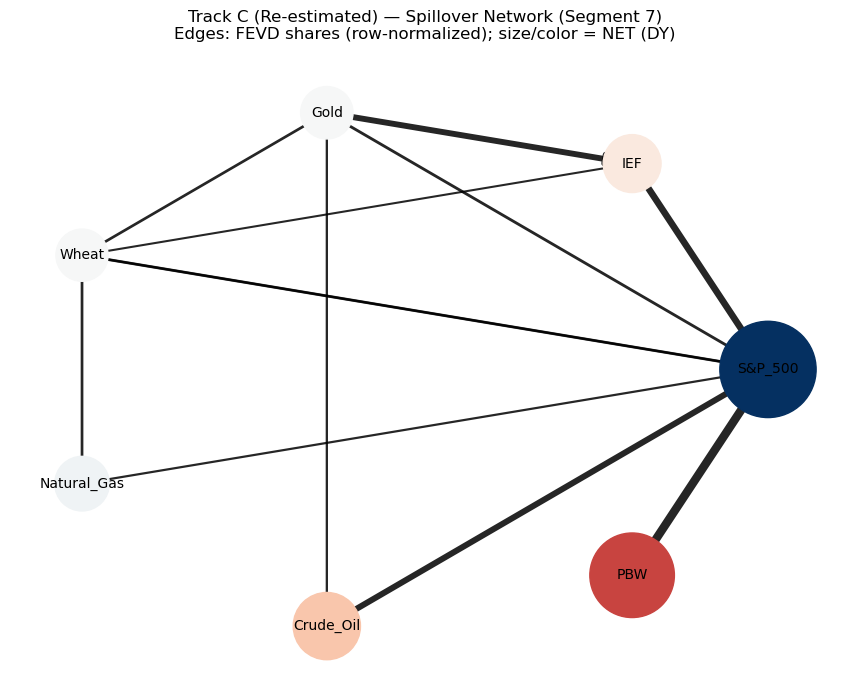

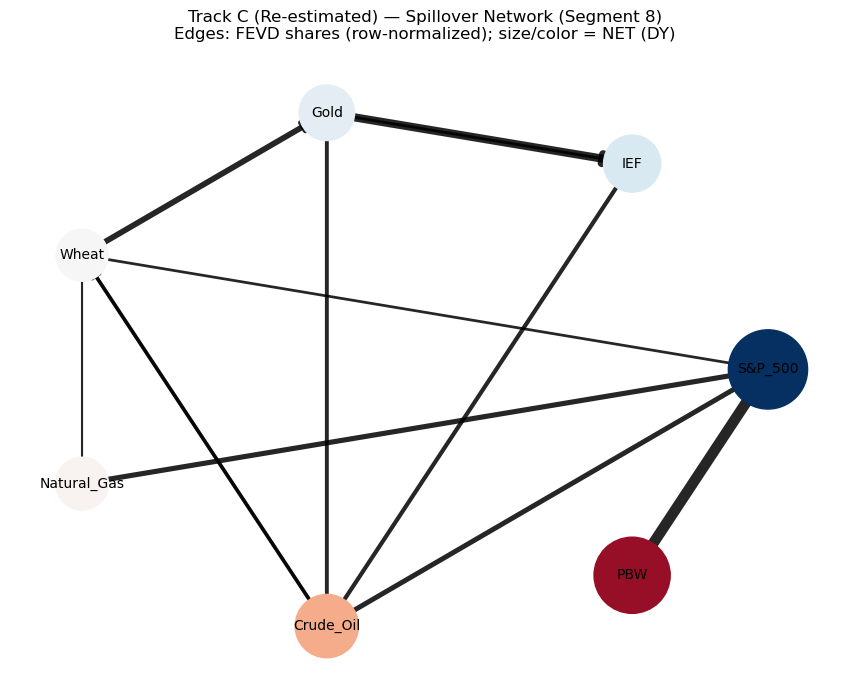

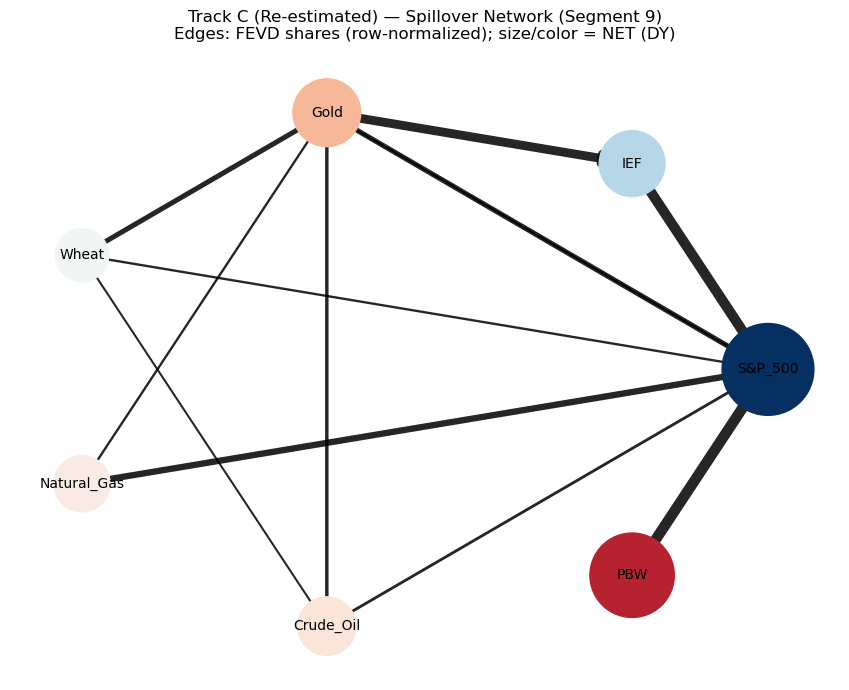

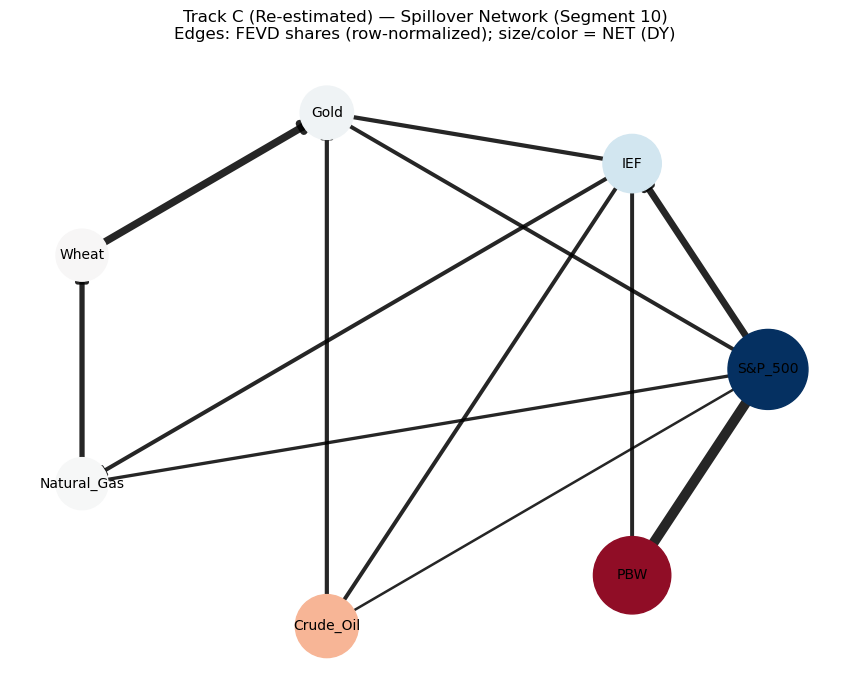

Saved per-segment network PNGs + edge lists to: /Users/mileshobson/outputs/regime_switching/trackC_networks


In [106]:
# === Track C (Re-estimated): Network plots per segment ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path
import re

out_dir = Path("outputs/regime_switching")
png_dir = out_dir / "trackC_networks"
png_dir.mkdir(parents=True, exist_ok=True)

# --- parameters you can tweak ------------------------------------------------
min_weight = 0.03      # drop very weak links (FEVD share < 3%)
keep_top   = 12        # or, after threshold, keep top-N strongest edges
arrowstyle = "-|>"     # arrow head
edge_alpha = 0.85
node_base  = 1400      # base node size
node_scale = 4500      # size added * |NET| (uses DY_measures if present)
width_scale = 8.0      # multiplies edge width ~ weight
cmap_name = "RdBu"     # diverging cmap for NET: blue(+) tx, red(-) rx

# --- discover files ----------------------------------------------------------
fevd_files = sorted(out_dir.glob("trackC_reestimate_segment*_FEVD_matrix.csv"),
                    key=lambda p: int(re.search(r"segment(\d+)", p.stem).group(1)))
meas_files = {int(re.search(r"segment(\d+)", p.stem).group(1)): p
              for p in out_dir.glob("trackC_reestimate_segment*_DY_measures.csv")}

if not fevd_files:
    raise FileNotFoundError("No FEVD matrices found at outputs/regime_switching/trackC_reestimate_segment*_FEVD_matrix.csv")

# --- get a stable node order from the first FEVD file -----------------------
first_fevd = pd.read_csv(fevd_files[0], index_col=0)
assets_order = list(first_fevd.columns)  # keep consistent across segments

# circular layout for comparability
G_tmp = nx.DiGraph()
G_tmp.add_nodes_from(assets_order)
pos = nx.circular_layout(G_tmp)  # deterministic order

# color map for net (blue = transmitter, red = receiver)
cmap = plt.get_cmap(cmap_name)

def net_to_color(net_val, vmax):
    # map NET in [-vmax, vmax] to [0,1] then to cmap; transmitters (+) lean blue in RdBu
    vmax = max(vmax, 1e-8)
    x = (net_val + vmax) / (2*vmax)
    return cmap(x)

# --- loop through segments ---------------------------------------------------
index_rows = []
for f in fevd_files:
    seg = int(re.search(r"segment(\d+)", f.stem).group(1))
    M = pd.read_csv(f, index_col=0).reindex(index=assets_order, columns=assets_order)
    K = M.shape[0]

    # zero out diagonal; normalise rows just in case
    np.fill_diagonal(M.values, 0.0)
    row_sums = M.sum(axis=1).replace(0, np.nan)
    M = (M.T / row_sums).T.fillna(0.0)

    # build edge list
    edges = []
    for i, src in enumerate(assets_order):
        for j, dst in enumerate(assets_order):
            w = float(M.iloc[i, j])
            if i != j and w >= min_weight:
                edges.append((src, dst, w))
    # keep strongest N (optional)
    edges = sorted(edges, key=lambda x: x[2], reverse=True)[:keep_top]

    # get per-asset NET for node size/color if available
    net_series = None
    if seg in meas_files:
        _df = pd.read_csv(meas_files[seg])
        net_series = _df.set_index("Asset")["NET"].reindex(assets_order)
        vmax = float(np.nanmax(np.abs(net_series.values))) if net_series.notna().any() else 0.0
    else:
        net_series = pd.Series(0.0, index=assets_order)
        vmax = 0.0

    # build graph
    G = nx.DiGraph()
    G.add_nodes_from(assets_order)
    for src, dst, w in edges:
        G.add_edge(src, dst, weight=w)

    # node sizes/colors
    node_sizes = []
    node_colors = []
    for a in assets_order:
        nv = float(net_series.loc[a]) if a in net_series.index else 0.0
        node_sizes.append(node_base + node_scale * abs(nv))
        node_colors.append(net_to_color(nv, vmax if vmax > 0 else 1.0))

    # draw
    fig, ax = plt.subplots(figsize=(8.6, 7.0))
    ax.set_title(f"Track C (Re-estimated) — Spillover Network (Segment {seg})\n"
                 f"Edges: FEVD shares (row-normalized); size/color = NET (DY)", pad=14)

    # edges (width ~ weight)
    widths = [max(0.8, e[2] * width_scale) for e in edges]
    nx.draw_networkx_edges(G, pos, ax=ax,
                           edgelist=[(u,v) for u,v,_ in edges],
                           width=widths, alpha=edge_alpha,
                           arrows=True, arrowstyle=arrowstyle, arrowsize=16)

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)

    ax.axis("off")
    plt.tight_layout()

    # save figure
    png_path = png_dir / f"trackC_network_segment{seg}.png"
    plt.savefig(png_path, dpi=240)
    plt.show()

    # save edge list for traceability
    edf = pd.DataFrame(edges, columns=["Source","Target","Weight"]).sort_values("Weight", ascending=False)
    edf.to_csv(png_dir / f"trackC_network_segment{seg}_edges.csv", index=False)

    # index row for summary
    index_rows.append({"Segment": seg, "png": str(png_path.name), "edges_csv": f"trackC_network_segment{seg}_edges.csv",
                       "n_edges": len(edges)})

# write an index manifest
pd.DataFrame(index_rows).sort_values("Segment").to_csv(png_dir / "trackC_network_index.csv", index=False)
print("Saved per-segment network PNGs + edge lists to:", png_dir.resolve())


In [109]:
# === Make a contact sheet of Track C network PNGs ===========================
from pathlib import Path
import glob, re, math
from PIL import Image

net_dir = Path("outputs/regime_switching/trackC_networks")
out_path = net_dir / "trackC_networks_montage.png"

files = sorted(
    glob.glob(str(net_dir / "trackC_network_segment*.png")),
    key=lambda p: int(re.search(r"segment(\d+)", p).group(1))
)
if not files:
    raise FileNotFoundError("No segment PNGs found. Run the network plotting cell first.")

# Layout (tweak if you like)
cols = 3          # images per row
pad  = 12         # pixels between tiles & around edges
tile_w = 900      # width for each tile (keeps aspect)

# Use first image to set a consistent tile height
w0, h0 = Image.open(files[0]).size
tile_h = int(h0 * (tile_w / w0))

rows = math.ceil(len(files) / cols)
W = cols * tile_w + (cols + 1) * pad
H = rows * tile_h + (rows + 1) * pad

sheet = Image.new("RGB", (W, H), "white")

for i, fp in enumerate(files):
    img = Image.open(fp).convert("RGB").resize((tile_w, tile_h), Image.LANCZOS)
    r, c = divmod(i, cols)
    x = pad + c * (tile_w + pad)
    y = pad + r * (tile_h + pad)
    sheet.paste(img, (x, y))

sheet.save(out_path, quality=95)
print("Saved montage:", out_path.resolve())


Saved montage: /Users/mileshobson/outputs/regime_switching/trackC_networks/trackC_networks_montage.png


In [115]:
import pandas as pd
from pathlib import Path

# --- inputs (yours) ---
CSV_SEG_TABLE = "outputs/regime_switching/trackC_segment_summary.csv"  # has: Segment, Start, End, Days, Avg_Spillover
CSV_TOTAL     = "outputs/rolling/rolling_total_H10_W250_S5_fixed.csv"                   # to get the trading-day calendar (Date, Total_Spillover)
OUT_DAILY     = "outputs/trackC_segments.csv"                          # ML pipeline will read this

# 1) Calendar from total spillover dates (aligns with your target)
cal = pd.read_csv(CSV_TOTAL, parse_dates=["Date"])[["Date"]].drop_duplicates().sort_values("Date").reset_index(drop=True)

# 2) Load segment summary
seg = pd.read_csv(CSV_SEG_TABLE, parse_dates=["Start","End"])
need_cols = {"Segment","Start","End"}
missing = need_cols - set(seg.columns)
if missing:
    raise ValueError(f"Missing required columns in segment summary: {missing}")

seg = seg.sort_values("Start").reset_index(drop=True)

# If your calendar runs past the last End, extend the last segment to cover it
last_idx = seg.index[-1]
seg.loc[last_idx, "End"] = max(seg.loc[last_idx, "End"], cal["Date"].max())

# 3) Expand to daily labels (use [Start, next Start) for all but last segment; last is inclusive)
rows = []
for i, r in seg.iterrows():
    start = r["Start"]
    if i < len(seg) - 1:
        next_start = seg.loc[i+1, "Start"]
        end_excl = min(r["End"], next_start)
        mask = (cal["Date"] >= start) & (cal["Date"] < end_excl)
    else:
        end_incl = r["End"]
        mask = (cal["Date"] >= start) & (cal["Date"] <= end_incl)

    tmp = cal.loc[mask].copy()
    tmp["Regime_SegID"] = int(r["Segment"])
    rows.append(tmp)

daily = pd.concat(rows, axis=0).sort_values("Date").reset_index(drop=True)

# 4) Anti-leak: use yesterday’s segment during training
daily["Regime_SegID"] = daily["Regime_SegID"].shift(1)

# 5) Clean + save
daily = daily.dropna(subset=["Regime_SegID"]).astype({"Regime_SegID":"int64"})
Path(OUT_DAILY).parent.mkdir(parents=True, exist_ok=True)
daily.to_csv(OUT_DAILY, index=False)

print(daily.head(3))
print(daily.tail(3))
print(f"Saved -> {OUT_DAILY}")


        Date  Regime_SegID
1 2006-03-20             1
2 2006-03-27             1
3 2006-04-03             1
          Date  Regime_SegID
966 2025-06-09            10
967 2025-06-16            10
968 2025-06-24            10
Saved -> outputs/trackC_segments.csv
